In [1]:
from custom_tf_idf_transformer_class import CustomClassTfidfTransformer
from write_csv_and_push_data import cleaning_strings

from annoy import AnnoyIndex
from tqdm import tqdm
import numpy as np
import pandas as pd
import nltk
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

GET TABLES

In [2]:
julien_products_df = pd.read_csv("/home/jupyter/20231123_stage_vincent_products.csv", sep=",", engine="python")

In [96]:
with snowflake.get_snowflake_connection(**secrets) as con:
    lr_tmp = snowflake.query_snowflake_to_df(
    """
   WITH table_julien AS (
    WITH
        CATEGORY_LEVEL4_PERIMETER AS (
            SELECT DISTINCT PRODUCT_CATEGORY_LEVEL4_ID AS PRODUCT_CATEGORY_LEVEL4_ID
            FROM QUALISCORE_LAB.LAB_STAGE_VINCENT_CANAPES_WITH_PROPERTIES
        ),
        CATEGORY_LEVEL3_PERIMETER AS (
            SELECT DISTINCT
                C.PRODUCT_CATEGORY_LEVEL3_ID,
                C.PRODUCT_CATEGORY_LEVEL4_ID
            FROM CATEGORY_LEVEL4_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL4_ID = C.PRODUCT_CATEGORY_LEVEL4_ID
                AND PRODUCT_CATEGORY_DEPTH = 4
        ),
        CATEGORY_LEVEL3_PATH_PERIMETER AS (
            SELECT
                P.PRODUCT_CATEGORY_LEVEL3_ID,
                P.PRODUCT_CATEGORY_LEVEL4_ID,
                C.PRODUCT_CATEGORY_CODE_PATH
            FROM CATEGORY_LEVEL3_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL3_ID = C.PRODUCT_CATEGORY_LEVEL3_ID
                AND PRODUCT_CATEGORY_DEPTH = 3
        ),
        TRAFFIC AS (
            SELECT
                SEARCH_ID,
                SUM(VIEW_COUNT::FLOAT) AS VIEW_COUNT,
                SUM(CLICK_COUNT) AS CLICK_COUNT,
                SUM(TURNOVER) AS TURNOVER
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_TRACKING_KPI
            WHERE SNAPSHOT_DATE BETWEEN DATE('2023-11-24') - 119 AND DATE('2023-11-24')
                AND SITE_ID = 100
                AND AB_TESTING_GROUP = 'A'
                AND SEARCH_ID <> ''
                AND SEARCH_ID IS NOT NULL
            GROUP BY SEARCH_ID
        ),
        CUMULATIVE_TRAFFIC AS (
            SELECT
                SEARCH_ID,
                (
                    SUM(VIEW_COUNT)
                    OVER(
                        ORDER BY VIEW_COUNT DESC, TURNOVER DESC, CLICK_COUNT DESC
                        ROWS UNBOUNDED PRECEDING
                    )
                ) / (
                    SUM(VIEW_COUNT)
                    OVER()
                ) AS CUM_QP_TRAFFIC
            FROM TRAFFIC
        ),
        TRAFFIC_BINS AS (
            SELECT
                SEARCH_ID,
                FLOOR(
                    IFF(
                        CUM_QP_TRAFFIC = 1,
                        CUM_QP_TRAFFIC - 1e-5,
                        CUM_QP_TRAFFIC
                    ) * 10
                ) AS SEARCH_ID_GROUP
            FROM CUMULATIVE_TRAFFIC
        )
    SELECT
        LR.SEARCH_ID,
        T.SEARCH_ID_GROUP,
        P.PRODUCT_CATEGORY_CODE_PATH
    FROM CATEGORY_LEVEL3_PATH_PERIMETER AS P
    INNER JOIN SEARCH_SMT.SMT_SCH_DIM_SEARCH_LIST_CATEGORY_FILTER AS LR
        ON P.PRODUCT_CATEGORY_CODE_PATH = LR.CATEGORY_FILTER_PATH_CODE
        AND LR.SNAPSHOT_DATE = '2023-11-24'
        AND LR.SITE_ID = 100
        AND LR.AB_TESTING_SVC_COOKIE_GROUP = 'A'
    INNER JOIN TRAFFIC_BINS AS T
        ON LR.SEARCH_ID = T.SEARCH_ID),
    FULL_DATA AS (
    SELECT     rerank.search_id,
               ARRAY_AGG(DISTINCT rerank.product_id) AS product_id_list,
               page_number,
               search_id_group
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_PRODUCT_VIEW AS rerank
            JOIN table_julien
                ON table_julien.search_id = rerank.search_id
                WHERE rerank.site_id = 100
                AND rerank.snapshot_date >= DATE('2023-11-24')
            GROUP BY (rerank.search_id, page_number, search_id_group))
    SELECT * FROM full_data WHERE ARRAY_SIZE(product_id_list) >=1;
    """, con=con)
lr_tmp["product_id_list"] = lr_tmp.product_id_list.apply(eval)

In [95]:
print(lr_tmp.search_id.nunique())
lr_tmp.sort_values("search_id").head(50)

2579


,search_id,product_id_list,page_number,search_id_group
1226,1piecejacquardhoussedecanapeextensiblepelucher...,"[AUC1688400299155, AUC1692472322264, AUC078598...",1,7.0
464,1piecejacquardhoussedecanapeextensiblepelucher...,"[KIM1688982030567, GOT1687592094073, AUC697373...",1,4.0
20968,2canapes,"[OVO8178312070188, DMO1691135618192, SAL169924...",1,5.0
8275,2canapes,"[VGE1698397374751, VGE1698397244311, HOM366297...",2,5.0
8531,2places,"[A107972, HOM1694085954389, AUC7630377901452, ...",1,6.0
19737,2places,"[LIS3701061727840, ITA3663556462905, LIS169336...",1,9.0
8107,2places,"[DIV3610971391433, A125176, A126056, HOM169408...",1,3.0
14520,2places,"[ITA3663556354125, LOU3700538219871, AUC366355...",1,7.0
16423,2places,"[HOM3662970094273, ITA3663556420400, BAI358417...",1,4.0
14737,2places,"[BOJESSR8595EAGTN, 9121ENOIRMF3, OMA7388441128...",1,5.0


In [97]:
from cdiscount import config
from cdiscount import snowflake

secrets = config.load_secrets('secrets.yml', key='snowflake')
with snowflake.get_snowflake_connection(**secrets) as con:
    lr_df = snowflake.query_snowflake_to_df(
    """
   WITH table_julien AS (
    WITH
        CATEGORY_LEVEL4_PERIMETER AS (
            SELECT DISTINCT PRODUCT_CATEGORY_LEVEL4_ID AS PRODUCT_CATEGORY_LEVEL4_ID
            FROM QUALISCORE_LAB.LAB_STAGE_VINCENT_CANAPES_WITH_PROPERTIES
        ),
        CATEGORY_LEVEL3_PERIMETER AS (
            SELECT DISTINCT
                C.PRODUCT_CATEGORY_LEVEL3_ID,
                C.PRODUCT_CATEGORY_LEVEL4_ID
            FROM CATEGORY_LEVEL4_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL4_ID = C.PRODUCT_CATEGORY_LEVEL4_ID
                AND PRODUCT_CATEGORY_DEPTH = 4
        ),
        CATEGORY_LEVEL3_PATH_PERIMETER AS (
            SELECT
                P.PRODUCT_CATEGORY_LEVEL3_ID,
                P.PRODUCT_CATEGORY_LEVEL4_ID,
                C.PRODUCT_CATEGORY_CODE_PATH
            FROM CATEGORY_LEVEL3_PERIMETER AS P
            INNER JOIN REFERENTIEL_SMT.SMT_RFL_DIM_PRODUCT_CATEGORY AS C
                ON P.PRODUCT_CATEGORY_LEVEL3_ID = C.PRODUCT_CATEGORY_LEVEL3_ID
                AND PRODUCT_CATEGORY_DEPTH = 3
        ),
        TRAFFIC AS (
            SELECT
                SEARCH_ID,
                SUM(VIEW_COUNT::FLOAT) AS VIEW_COUNT,
                SUM(CLICK_COUNT) AS CLICK_COUNT,
                SUM(TURNOVER) AS TURNOVER
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_TRACKING_KPI
            WHERE SNAPSHOT_DATE BETWEEN DATE('2023-11-24') - 119 AND DATE('2023-11-24')
                AND SITE_ID = 100
                AND AB_TESTING_GROUP = 'A'
                AND SEARCH_ID <> ''
                AND SEARCH_ID IS NOT NULL
            GROUP BY SEARCH_ID
        ),
        CUMULATIVE_TRAFFIC AS (
            SELECT
                SEARCH_ID,
                (
                    SUM(VIEW_COUNT)
                    OVER(
                        ORDER BY VIEW_COUNT DESC, TURNOVER DESC, CLICK_COUNT DESC
                        ROWS UNBOUNDED PRECEDING
                    )
                ) / (
                    SUM(VIEW_COUNT)
                    OVER()
                ) AS CUM_QP_TRAFFIC
            FROM TRAFFIC
        ),
        TRAFFIC_BINS AS (
            SELECT
                SEARCH_ID,
                FLOOR(
                    IFF(
                        CUM_QP_TRAFFIC = 1,
                        CUM_QP_TRAFFIC - 1e-5,
                        CUM_QP_TRAFFIC
                    ) * 10
                ) AS SEARCH_ID_GROUP
            FROM CUMULATIVE_TRAFFIC
        )
    SELECT
        LR.SEARCH_ID,
        P.PRODUCT_CATEGORY_CODE_PATH
    FROM CATEGORY_LEVEL3_PATH_PERIMETER AS P
    INNER JOIN SEARCH_SMT.SMT_SCH_DIM_SEARCH_LIST_CATEGORY_FILTER AS LR
        ON P.PRODUCT_CATEGORY_CODE_PATH = LR.CATEGORY_FILTER_PATH_CODE
        AND LR.SNAPSHOT_DATE = '2023-11-24'
        AND LR.SITE_ID = 100
        AND LR.AB_TESTING_SVC_COOKIE_GROUP = 'A'
    INNER JOIN TRAFFIC_BINS AS T
        ON LR.SEARCH_ID = T.SEARCH_ID
    WHERE SEARCH_ID_GROUP = 8 or SEARCH_ID_GROUP = 9),
    FULL_DATA AS (
    SELECT     rerank.search_id,
               ARRAY_AGG(DISTINCT rerank.product_id) AS product_id_list,
               page_number
            FROM SEARCH_SMT.SMT_SCH_AGG_SEARCH_LIST_PRODUCT_VIEW AS rerank
            JOIN table_julien
                ON table_julien.search_id = rerank.search_id
                WHERE rerank.site_id = 100
                AND rerank.snapshot_date >= DATE('2023-11-24')
            GROUP BY (rerank.search_id, page_number))
    SELECT * FROM full_data WHERE ARRAY_SIZE(product_id_list) >=1;
    """, con=con)
lr_df["product_id_list"] = lr_df.product_id_list.apply(eval)

In [80]:
lr_df # Group 1 and 2

,search_id,product_id_list,page_number
0,canape2place,"[VGE1698429874682, ATY1698272550220, MIC590361...",3
1,canapescandinave3places,"[CUQ7400446189230, DRF1696200345412, ATY169412...",14
2,canapechesterfielvelour,"[VEN3666471043600, AUC3760002170343, BEL425168...",1
3,houssedecanapedangleavecreposetete,"[AUC1696669221703, AUC1701306786307, AUC168840...",1
4,canapedanglecuir,"[VEN3517920899609, VID8718475525028, MOT168916...",2
...,...,...,...
3436,canapedangleconvertible5place,"[BES3701061714543, AUC3701521813618, BAI168744...",5
3437,canape3placesbeige,"[TOU1689675140692, BET1699888453556, HOM168623...",2
3438,canaperdangleconvertible4placecouleurgris,"[LIS3701061715304, AUC3700538220730, LIS370106...",2
3439,canapeconvertible2placesaveccoffrederangement,"[LIS3701061714406, HOM5903814785000, HOM590381...",3


In [78]:
lr_df # Group 8 and 9 onyxcanapepanoramiquedanglegauche7placesentiss

,search_id,product_id_list,page_number
0,canape2place,"[HAB2009858698993, VEN3517920979141, AUC938856...",3
1,canapesimilicuirgris,"[VEN3517920895700, AUC5903313147163, AUC370101...",4
2,canapechesterfieldnoir,"[VGE9792937341615, YOS1701621645566, AUC907337...",3
3,canapebleumarine,"[EME1690265576942, SEL1696487882987, MIL366227...",2
4,houssedecanapedangleavecreposetete,"[CAL0735280359196, AUC2009101537994, ROK168535...",1
...,...,...,...
4557,houssesdecanape3places,"[CAL6973735847810, AUC1695647208587, OLY695260...",3
4558,canapedangleconvertiblesimilicuir,"[HAP3795120373420, HAB3700746474062, AUC370101...",1
4559,canape3place,"[MIC5903614362807, LIS1688566786889, VGE169839...",6
4560,canapedangleencuir,"[QQM1691995189771, DES3760250736636, VEN169732...",5


In [5]:
exploded_lr_df = lr_df.explode("product_id_list")
exploded_lr_df.drop_duplicates(subset=["product_id_list"], inplace=True)
julien_products_df.reset_index(inplace=True)
full_df = julien_products_df.merge(exploded_lr_df, left_on="product_id", right_on="product_id_list")
full_df.rename(columns={'fp_product_name':'product_name', 'product_long_description':'description'}, inplace=True)
full_df.description.fillna("", inplace=True)
full_df.description = cleaning_strings(full_df.description)
full_df.product_name = cleaning_strings(full_df.product_name)
full_df.drop(columns=['product_id_list',
                      'product_short_description',
                      'product_properties',
                      'preprocessed_product_properties',
                      'product_marketing_description',
                      'total_token_fp_product_name',
                      'total_token_product_long_description',
                      'total_token_fp_content',
                      #'community_id'
                     ], inplace=True)

In [6]:
full_df.to_csv("csv_files/lr_long_tail_products.csv", index=False, sep='\u0001')

ANNOY-ING NEIGHBORS

In [8]:
def id2product_id(index):
    return full_df.iloc[index].product_id

def get_neighbors(u, i, k):
    neighbors, distances = u.get_nns_by_item(i=i, n=k+1, include_distances=True)
    return (
      pd.DataFrame({
          'id': i,
          'neighbor_id': neighbors,
          'distance': distances
      })
      .loc[lambda x: x.neighbor_id.ne(i)]
      .head(k)
      .assign(rank=[j for j in range(1, k+1)])
    )

In [9]:
index_list = full_df["index"]
vec_dim = 1536
original_annoy_index = AnnoyIndex(vec_dim, 'dot')
original_annoy_index.load('/home/jupyter/20231123_stage_vincent_products_fp_content.ann')
u = AnnoyIndex(vec_dim, 'dot')
new_idx = 0
for i in tqdm(index_list, total=len(index_list)):
    vector = original_annoy_index.get_item_vector(i)
    u.add_item(new_idx, vector)
    new_idx += 1
u.build(100)

100%|██████████| 52262/52262 [00:03<00:00, 14915.23it/s]


True

In [10]:
saving_csv=True
all_neighbors = []
for i in tqdm(range(0, u.get_n_items())):
    all_neighbors.append(get_neighbors(u=u, i=i, k=10))
all_neighbors = pd.concat(all_neighbors)
all_neighbors['id'] = all_neighbors['id'].apply(id2product_id)
all_neighbors['neighbor_id'] = all_neighbors['neighbor_id'].apply(id2product_id)
scaler = MinMaxScaler()
all_neighbors['distance'] = scaler.fit_transform(all_neighbors[['distance']])
if saving_csv:
    all_neighbors.to_csv("csv_files/lr_long_tail_product_product.csv", index=False, sep='\u0001')
    
# all_neighbors[["id", "neighbor_id"]].apply(lambda x: " | ".join(np.sort(x)), axis=1).nunique()

100%|██████████| 52262/52262 [01:37<00:00, 536.69it/s]


In [11]:
product_id = 'ZJC7686514932339'

print(full_df[full_df.product_id == product_id].product_name.item())
for neighbor in all_neighbors[all_neighbors.id == product_id].neighbor_id.tolist():
    print("    ", full_df[full_df.product_id == neighbor].product_name.item())

sib canape lit a 2places et deux oreillers rouge bordeaux velours 7686514932339
     zjchao canape lit a 2places et deux oreillers rouge bordeaux velours zjc7458882915302
     sib canape lit a 2places rouge bordeaux tissu 7902196494720
     zjchao canape lit a 2places et deux oreillers rouge bordeaux velours zjc7458882915388
     sal canape lit a 2places et deux oreillers rouge bordeaux velours 7388289548059
     zhi canape lit a 2places et deux oreillers rouge bordeaux velours 7386502626102
     liu 7848336949463canape lit a 2places et deux oreillers rouge bordeaux velours
     liu 7809355700954canape lit a 2places et deux oreillers rouge bordeaux velours
     coc 7596638026763canape lit a 2places et deux oreillers rouge bordeaux velours
     canape lit a 2places et deux oreillers rouge bordeaux velours dilwe7842688982987
     er1680 canape lit a 2places et deux oreillers rouge bordeaux velours ab337622 111680


PUSH TO NEO4J

In [13]:
from neo4j import GraphDatabase, basic_auth
username = "neo4j"
password = "zDje683kEKpo23"
driver = GraphDatabase.driver(uri="bolt://a08datasc002.cdbdx.biz:7687", auth=(username, password))

cleaning_all = '''
MATCH (n)
DETACH DELETE n
'''
products_idx = '''
CREATE INDEX products_constraint IF NOT EXISTS FOR (n:Product) ON n.product_id;
'''
# product_property_value,product_id,product_category_level4_id,product_category_level4_name,product_long_description
create_products_nodes = '''
LOAD CSV WITH HEADERS FROM 'file:///var/lib/neo4j/import/lr_long_tail_products.csv' AS product_line FIELDTERMINATOR '\u0001'
// Create products
MERGE (p:Product
            {product_id: product_line.product_id,
             product_name: COALESCE(product_line.fp_product_name, "empty"),
             description: COALESCE(product_line.product_long_description, "empty")
             })
'''
product_product_relationship = '''
// Create a relationship between the products
CALL apoc.periodic.iterate(
  '
  LOAD CSV WITH HEADERS FROM "file:///var/lib/neo4j/import/lr_long_tail_product_product.csv" AS line FIELDTERMINATOR "\u0001"
  RETURN line
  ',
  '
  MATCH (p:Product {product_id: line.id})
  MATCH (neighbor:Product {product_id: line.neighbor_id})
  MERGE (p)-[:Neighbors]->(neighbor)
  MERGE (neighbor)-[:Neighbors]->(p)
  ',
  {batchSize: 5000, iterateList: true}
)
'''

product_product_relationship_weighted = '''
// Create a weighted relationship between the products
CALL apoc.periodic.iterate(
  '
  LOAD CSV WITH HEADERS FROM "file:///var/lib/neo4j/import/lr_long_tail_product_product.csv" AS line FIELDTERMINATOR "\u0001"
  RETURN line
  ',
  '
  MATCH (p:Product {product_id: line.id})
  MATCH (neighbor:Product {product_id: line.neighbor_id})
  MERGE (p)-[r:Neighbors {weight: toFloat(line.distance)}]->(neighbor)
  MERGE (neighbor)-[:Neighbors {weight: toFloat(line.distance)}]->(p)
  ',
  {batchSize: 5000, iterateList: true}
)
'''

cleaning_before_pushing=True
weighted_relationship=True

with driver.session(database="neo4j") as session:
    if cleaning_before_pushing:
        session.execute_write(
            lambda tx: tx.run(cleaning_all).data())
        print("Cleaning done")
    session.execute_write(
        lambda tx: tx.run(products_idx).data())
    print("Indexes done")
    session.execute_write(
        lambda tx: tx.run(create_products_nodes).data())
    print("Product nodes added")
    if weighted_relationship:
        session.execute_write(
            lambda tx: tx.run(product_product_relationship_weighted).data())
    else:
        session.execute_write(
            lambda tx: tx.run(product_product_relationship).data())
    print("product_product relationships added")
driver.close()


Cleaning done
Indexes done
Product nodes added
product_product relationships added


ANALYSE DE COMMUNAUTES

In [14]:
#from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer

def extract_vocabulary(documents, stop_words, min_len: int = 3, min_df: int = 2):
    vocabulary = ' '.join(documents)
    vocabulary = [w for w in vocabulary.split() if w not in stop_words]
    vocabulary = Counter(vocabulary)
    for k, v in vocabulary.most_common():
        if v < min_df or len(k) < min_len:
            del vocabulary[k]
    return [k for k, _ in vocabulary.most_common()]

def merge_columns(row):
    return f"{' '.join(row['product_name_list'])} {row['description']}"

def get_top_words(response, threshold, feature_array):
    #response_normalized = normalize(response, axis=1, norm='l2')
    response_normalized = custom_norm(response.toarray())
    response_normalized = response_normalized.reshape(-1)
    sorted_nzs = np.argsort(response_normalized.data)[::-1]
    feature_array = feature_array[sorted_nzs]
    response_normalized = response_normalized[sorted_nzs]
    response_normalized = response_normalized > threshold
    res = feature_array[response_normalized]
    return np.apply_along_axis(' | '.join, 0, res)

def custom_norm(x):
    norm = x.sum(axis=1)
    return x / norm

# TF-IDF METHOD
def add_tf_idf_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    v = CustomClassTfidfTransformer(use_idf=True)
    x = v.fit_transform(vector)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in x]

# COUNT VECTORIZER METHOD
def add_count_vectorizer_words(document_list, stopwords, threshold):
    vectorizer = CountVectorizer(vocabulary=extract_vocabulary(documents=document_list, stop_words=stopwords))
    vector = vectorizer.transform(document_list)
    features = np.array(vectorizer.get_feature_names_out())
    return [get_top_words(response=item, threshold=threshold, feature_array=features) for item in vector]

In [24]:
#full_df.drop(columns=["community_id_x", "community_id_y"], inplace=True)
exploded_lr_df.drop(columns=["community_id_x", "community_id_y"], inplace=True)

In [35]:
full_df.drop(columns=["community_id"], inplace=True)
exploded_lr_df.drop(columns=["community_id"], inplace=True)

In [37]:
full_df.columns
#exploded_lr_df.columns

Index(['index', 'product_id', 'brand_name', 'product_name', 'description',
       'fp_content', 'search_id', 'page_number'],
      dtype='object')

In [47]:
communities_df.

,description,community_size,product_id_list,product_name_list,page_number_list,document,count_vectorizer_top_words,tf_idf_top_words
community_id,,,,,,,,
12602,vous cherchez un joli petit canape d angle con...,3026,"[MEU2008922378083, VEN1692836135725, ATM356023...",[portos canape d angle angle gauche gris blanc...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",portos canape d angle angle gauche gris blanc ...,canape | angle | convertible | tissu,
17114,couleur marron materiau cadre en bois reveteme...,2512,"[HIL2008150770628, DUO2007809146654, AUC501160...",[canape lit convertible avec_accoudoir daim sy...,"[3, 3, 3, 3, 3, 3, 3, 12, 12, 12, 12, 12, 12, ...",canape lit convertible avec_accoudoir daim syn...,canape | dimensions | lit | hauteur | siege,168x | 168cm | transformation | 41cm | ajustab...
11221,couleur creme. materiau cadre en bois et tapis...,2357,"[DIO7049491646949, DRF1696190657354, VEN351792...",[canape a 3places tissu creme dioche7049491646...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",canape a 3places tissu creme dioche70494916469...,siege | canape | dimensions | hauteur | partir...,
46512,matiere excellente les housses de canape en ti...,2284,"[SUB2008442269823, INS0854136299346, INS085413...",[subrtex 1 piece housse de canape extensible h...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",subrtex 1 piece housse de canape extensible ho...,canape | housse,
14101,zjc7686514932339 couleur rouge bordeaux. mater...,2025,"[ZJC7686514932339, VBE7434407900879, ZER169858...",[sib canape lit a 2places et deux oreillers ro...,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",sib canape lit a 2places et deux oreillers rou...,hauteur | siege | canape | lit | materiau | di...,69cm | 32cm | 845x | position | hauteur | plas...
...,...,...,...,...,...,...,...,...
18922,tout est dans le nom unwind c est le canape id...,14,"[INS3663556443164, INS3663556443102, INS366355...",[canape convertible futon unwind pin naturel c...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",canape convertible futon unwind pin naturel co...,canape | unwind | cinema,unwind | cinema | attend | soiree | relaxer | ...
17353,vendu par piece pas toutes les pieces les hous...,13,"[AUC1696660576091, AUC1696660514259, AUC169666...",[housse de canape 4 3 2 1 places places avec_a...,"[3, 5, 5, 5, 6, 6, 5, 5, 1, 1, 1, 1, 4]",housse de canape 4 3 2 1 places places avec_ac...,canape | places | angle | sdnam | housse | design,sdnam | tou | maintient | collecter | ameliore...
47404,accoudoirs ultra fins pour_un gain de place op...,12,"[INS3663556138107, INS3663556138121, INS366355...",[canape d angle luna express 140 197 16 cm som...,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3]",canape d angle luna express 140 197 16 cm somm...,ouverture | express | matelas | canape | luna ...,luna | fins | 197 | ultra | ouverture | optimu...


In [38]:
# Creating communities_df

stop_words = ["sous", "sur", "en", "a", "d", "l", "de", "du", "des", "le", "la", "les", "un", "une", "mais", "ou", "et", "donc", "or", "ni", "car", "ce", "se", "ces", "ses", "ne", "pas", "tout", "tous", "toute", "toutes"]
stop_words += ["je", "tu", "il", "elle", "nous", "vous", "ils", "elles"]
stop_words += nltk.corpus.stopwords.words('french')

product_community_df = pd.read_csv("csv_files/communities_analysis/lr_long_tail_communities_products.csv", sep=",", engine="python")

full_df = full_df.merge(product_community_df, on='product_id') # Adding the column 'community_id' to full_df
exploded_lr_df = exploded_lr_df.rename(columns={'product_id_list':'product_id'}).merge(full_df[['community_id', 'product_id']], on='product_id')
communities_df = full_df.groupby('community_id')['description'].apply(lambda x: " | ".join(x)).reset_index()
communities_df.set_index("community_id", inplace=True)

# Community size
count = full_df.groupby('community_id').product_id.count().reset_index()
count.set_index("community_id", inplace=True)
communities_df["community_size"] = count.product_id
len_before = len(communities_df)
communities_df.drop(communities_df[communities_df.community_size < 2].index, inplace=True)
len_after = len(communities_df)
print(f"len before is:{len_before} | len after is:{len_after}")


# Community Lists
communities_df["product_id_list"] = full_df.groupby("community_id").product_id.apply(list)
communities_df["product_name_list"] = full_df.groupby("community_id").product_name.apply(list)

temp_df = exploded_lr_df.dropna().merge(full_df, on='product_id')
temp_df.drop(columns=['search_id_x', 'search_id_y', 'community_id_x', 'brand_name', 'description', 'fp_content', 'page_number_x'], inplace=True)
temp_df.rename(columns={'community_id_y':'community_id', 'page_number_y':'page_number'}, inplace=True)
communities_df["page_number_list"] = temp_df.groupby("community_id").page_number.apply(list)
del temp_df
#communities_df["category_name_list"] = full_df.groupby("community_id").category_name.apply(list)
#communities_df['category_counts'] = communities_df['category_name_list'].apply(lambda x: dict(Counter(x)))


# TF-IDF and CountVectorizer
communities_df['document'] = communities_df.apply(merge_columns, axis=1)
communities_df['count_vectorizer_top_words'] = add_count_vectorizer_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.025)
communities_df['tf_idf_top_words'] = add_tf_idf_words(document_list=communities_df.document, stopwords=stop_words, threshold=0.015)

communities_df = communities_df.sort_values("community_size", ascending=False)

len before is:130 | len after is:130


/home/jupyter/icarusight/neo4j/custom_tf_idf_transformer_class.py:69: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)


In [48]:
# Get the top 5 search ids
temp_df = exploded_lr_df.dropna().groupby('community_id', as_index=True).search_id.apply(lambda x: x.value_counts(normalize=True).head(5)).reset_index()
temp_df['search_id'] = temp_df.apply(lambda x: f"{x['level_1']}: {x['search_id']}", axis=1)
temp_df.drop(columns='level_1', inplace=True)
temp_df = temp_df.groupby('community_id').apply(lambda x: list(x.search_id)).rename("top_search_id_list").reset_index()
communities_df = communities_df.merge(temp_df, on='community_id', how='left')
communities_df['top_search_id_list'] = communities_df['top_search_id_list'].fillna("").apply(list)
communities_df.set_index('community_id', inplace=True)
del temp_df

In [50]:
# All neighbors df buffed with communities (product_id/communities/distances mapping)

communities_distances_df = all_neighbors.merge(full_df, left_on='neighbor_id', right_on='product_id', how='inner')
communities_distances_df.rename(columns={'community_id': 'neighbor_community_id'}, inplace=True)
communities_distances_df.drop(columns=["product_id"], inplace=True)
communities_distances_df = communities_distances_df.merge(full_df, left_on='id', right_on='product_id', how='inner')
communities_distances_df.drop(columns=["product_id"], inplace=True)

In [51]:
infos = communities_distances_df[communities_distances_df.community_id == 
            communities_distances_df.neighbor_community_id].groupby('community_id').agg(
                dmean=("distance", "mean"),
                dmedian=("distance", lambda x: np.quantile(x,0.5)),
                quantile_025=("distance", lambda x: np.quantile(x,0.25)),
                quantile_095=("distance", lambda x: np.quantile(x,0.95)),
                quantile_005=("distance", lambda x: np.quantile(x,0.05))
            )
infos['community_size'] = communities_df['community_size']
infos.sort_values('community_size', ascending=True, inplace=True)
infos['len_edges'] = communities_distances_df.loc[communities_distances_df.community_id == communities_distances_df.neighbor_community_id].groupby('community_id').count().id
infos['density'] = (infos['len_edges']) / (infos['community_size'] * 10)

infos.sort_values('dmean', ascending=False, inplace=True)
print(len(infos))
display(infos)

130


,dmean,dmedian,quantile_025,quantile_095,quantile_005,community_size,len_edges,density
community_id,,,,,,,,
29515,0.997452,0.997599,0.996933,0.998797,0.995354,89,890,1.000000
5290,0.992196,0.992687,0.991190,0.995479,0.985713,50,496,0.992000
46259,0.985878,0.990881,0.988165,0.994982,0.976819,183,1550,0.846995
23013,0.982726,0.993307,0.958562,0.998233,0.954941,15,150,1.000000
46779,0.982270,0.982982,0.977371,0.991635,0.970520,27,270,1.000000
...,...,...,...,...,...,...,...,...
12602,0.801519,0.798680,0.692589,0.978863,0.610741,3026,27224,0.899670
10283,0.793300,0.771381,0.692144,0.977463,0.612094,518,4569,0.882046
45582,0.788722,0.789567,0.692334,0.964090,0.610378,1286,10207,0.793701


In [52]:
lr_df[lr_df.product_id_list.apply(lambda x: 'AUC8737752324949' in x)]
lr_df[lr_df.search_id == 'auc8737752324949'].product_id_list

2321    [AUC8416089715940, AUC8737752173790, BD51684, ...
Name: product_id_list, dtype: object

In [53]:
exploded_lr_df

,search_id,product_id,page_number,community_id
0,canape2place,HAB2009858698993,3,41813
1,canape2place,VEN3517920979141,3,45582
2,canape2place,AUC9388565133748,3,41813
3,canape2place,ATY1698272726338,3,23104
4,canape2place,MIL3662275126150,3,51131
...,...,...,...,...
47347,canapesalon,FAF1691983742834,10,9475
47348,canapesalon,ZER1691054725521,10,9475
47349,houssecanapeextensible,AUC1687339943627,2,2525
47350,houssecanapeextensible,HAO6765879999773,2,29854


In [54]:
(exploded_lr_df.groupby('search_id', as_index=False)
.agg(
    n_community=("community_id", "nunique"),
    n_products=("product_id", "nunique")
)
 .assign(avg_number_by_community=lambda x: x.n_products.divide(x.n_community))
).sort_values('avg_number_by_community', ascending=False).head(20)

,search_id,n_community,n_products,avg_number_by_community
10,canape,84,6337,75.440476
48,canape3places,72,4181,58.069444
211,canapedangle,39,1918,49.179487
23,canape2places,54,2554,47.296296
520,houssecanape3places,26,923,35.500000
568,houssedecanape,35,1121,32.028571
120,canapechesterfield,10,320,32.000000
468,clicclac,24,699,29.125000
642,minicanape,5,136,27.200000
580,houssedecanape4placesavecaccoudoirs,7,180,25.714286


In [55]:
exploded_lr_df['main_lr_community'] = (
    exploded_lr_df
    .groupby('search_id').community_id.transform(lambda x: pd.Series.mode(x)[0])
)
exploded_lr_df.head(20)

,search_id,product_id,page_number,community_id,main_lr_community
0,canape2place,HAB2009858698993,3,41813,30775
1,canape2place,VEN3517920979141,3,45582,30775
2,canape2place,AUC9388565133748,3,41813,30775
3,canape2place,ATY1698272726338,3,23104,30775
4,canape2place,MIL3662275126150,3,51131,30775
5,canape2place,ATY1698286939668,3,23104,30775
6,canape2place,VGE1698404581812,3,30775,30775
7,canape2place,OVO3500605634831,3,28513,30775
8,canape2place,AUC3327480027455,3,45582,30775
9,canape2place,OVO2008699922861,3,11221,30775


In [56]:
exploded_lr_df.loc[lambda x: x.community_id.eq(29489) & x.search_id.eq('canapechesterfield')].merge(full_df[['product_id', 'product_name']], how='inner', on='product_id').product_name.values

array([], dtype=object)

In [57]:
lr_community_belonging_rate = (
    exploded_lr_df
    [['search_id', 'product_id', 'community_id', 'main_lr_community']]
    .drop_duplicates()
    .assign(
        is_inside_main_community=lambda x: x.community_id.eq(x.main_lr_community),
    )
    .groupby(['search_id', 'main_lr_community'], as_index=False)
    .agg(
        n_obs=('is_inside_main_community', 'size'),
        n_conv=('is_inside_main_community', 'sum'),
        rate=('is_inside_main_community', 'mean'),
    )
)
lr_community_belonging_rate.head(3)

,search_id,main_lr_community,n_obs,n_conv,rate
0,auc0755886164390,46512,7,5,0.714286
1,bancavecaccoudoir,23842,1,1,1.000000
2,banquetteangle,17114,15,7,0.466667


In [58]:
from scipy.stats import beta

def get_conversion_rate(n: int, n_conv: int, quantile: float = 0.025):
    a, b = 1 + n_conv, 1 + n - n_conv
    cv = beta(a, b)
    return {'q1': cv.ppf(quantile), 'median': cv.ppf(0.5), 'qn': cv.ppf(1.0 - quantile)}

In [59]:
lr_community_belonging_rate['rate_q1'] = get_conversion_rate(n=lr_community_belonging_rate.n_obs, n_conv=lr_community_belonging_rate.n_conv, quantile=0.01)['q1']
lr_community_belonging_rate['rate_median'] = get_conversion_rate(n=lr_community_belonging_rate.n_obs, n_conv=lr_community_belonging_rate.n_conv, quantile=0.01)['median']

In [60]:
lr_community_belonging_rate.head(20)

,search_id,main_lr_community,n_obs,n_conv,rate,rate_q1,rate_mean
0,auc0755886164390,46512,7,5,0.714286,0.293230,0.679481
1,bancavecaccoudoir,23842,1,1,1.000000,0.100000,0.707107
2,banquetteangle,17114,15,7,0.466667,0.211716,0.469408
3,banquetteclicclac,17114,87,21,0.241379,0.150489,0.245291
4,banquetteclicclac3places,49865,29,12,0.413793,0.227961,0.417599
5,banquetteconvertible3placesteijo,23842,13,10,0.769231,0.443331,0.743916
6,banquettedangle,17114,9,6,0.666667,0.297116,0.644900
7,banquettemodulable,5893,21,11,0.523810,0.288129,0.522380
8,bobochic,12602,2,2,1.000000,0.215443,0.793701
9,bznoir,23842,1,1,1.000000,0.100000,0.707107


<Axes: ylabel='Frequency'>

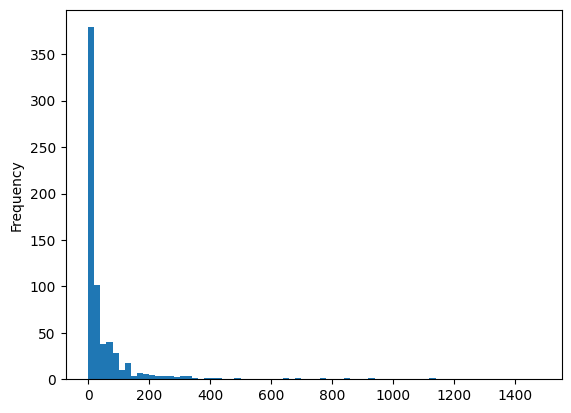

In [61]:
lr_community_belonging_rate.n_obs.plot.hist(bins=np.arange(0, 1500, 20))

In [62]:
lr_community_belonging_rate.sort_values('rate_q1', ascending=False).head(20)

,search_id,main_lr_community,n_obs,n_conv,rate,rate_q1,rate_mean
120,canapechesterfield,41813,320,303,0.946875,0.910443,0.945017
227,canapedanglechesterfield,41813,137,120,0.875912,0.797086,0.872282
474,clicclacconvertible,17114,19,19,1.000000,0.794328,0.965936
633,houssesdecanapedangle5places,24099,98,86,0.877551,0.781993,0.872469
102,canapeavecpouf,32309,16,16,1.000000,0.762699,0.960047
651,protegeaccoudoircanape,17516,15,15,1.000000,0.749894,0.957603
382,canapepatchwork,32309,65,55,0.846154,0.717892,0.839172
541,houssecanapedanglepanoramique,22298,25,23,0.920000,0.714055,0.898474
281,canapedanglerond,22208,24,22,0.916667,0.704070,0.894467
642,minicanape,39142,136,108,0.794118,0.703719,0.791258


In [65]:
lr_infos = exploded_lr_df.dropna().groupby('search_id', as_index=True).community_id.apply(lambda x: x.value_counts(normalize=True).head(5)).reset_index()
lr_infos['community_id'] = lr_infos.apply(lambda x: f"{x['level_1']}: {x['community_id']}", axis=1)
lr_infos.drop(columns='level_1', inplace=True)
lr_infos = lr_infos.groupby('search_id').apply(lambda x: list(x.community_id)).rename("top_community_id_list").reset_index()
lr_infos

,search_id,top_community_id_list
0,auc0755886164390,"[46512: 0.7142857142857143, 16966: 0.142857142..."
1,bancavecaccoudoir,[23842: 1.0]
2,banquetteangle,"[17114: 0.4666666666666667, 41813: 0.333333333..."
3,banquetteclicclac,"[17114: 0.2413793103448276, 45933: 0.172413793..."
4,banquetteclicclac3places,"[49865: 0.41379310344827586, 42927: 0.17241379..."
...,...,...
666,sofabed,"[28513: 0.5714285714285714, 17114: 0.142857142..."
667,sofaconvertible,"[36124: 0.6133333333333333, 45933: 0.213333333..."
668,tetierepourcanape,"[5914: 0.3076923076923077, 12602: 0.2692307692..."
669,velourscotele,"[12602: 0.5, 32309: 0.5]"


In [75]:
def look4one_community(idx):
    row = communities_df.loc[idx]
    row_infos = infos.loc[idx]
    print("\n\t------INFOS------")
    print(f"Mean: {row_infos.dmean} | Median: {row_infos.dmedian} | Density: {row_infos.density} | Community_size: {row.community_size}\n",
          f"| Quantile 25%: {row_infos.quantile_025} | Quantile 95%: {row_infos.quantile_095} | Quantile 5%: {row_infos.quantile_005}")
    print("\t------TOP_SEARCH_IDs------")
    for s_id in row.top_search_id_list:
        print(f"{s_id}")
    print("\t------PRODUCTS_NAME_SAMPLE------")
    products_list = row.product_name_list[:25]
    for product in products_list:
        print(product)
    print(end="\n\n" + "-" * 150 + "\n")
    
def look4one_lr(search_id):
    row = lr_infos[lr_infos.search_id == search_id]
    print("\n\t------INFOS------")
    print("\t------TOP_SEARCH_IDs------")
    for community_id in row.top_community_id_list:
        print(f"{community_id}")

In [72]:
temp_df = full_df
#temp_df.set_index('search_id', inplace=True)
temp_df = temp_df.groupby('search_id').community_id.apply(lambda x: x.value_counts().head(5)).reset_index()
#temp_df.rename(columns={'community_id':'com_id'}, inplace=True)
temp_df.sort_values('community_id', ascending=False, inplace=True)
display(temp_df)
del temp_df

,search_id,level_1,community_id
180,canape3places,11221,582
28,canape,3466,516
181,canape3places,12602,487
29,canape,14101,451
790,canapedangleconvertible,17114,429
...,...,...,...
2232,meridiennemarron,9536,1
2235,meridiennenoire,23842,1
2236,meridiennenoire,11489,1
2240,minicanape,9268,1


In [71]:
print(infos.columns)
infos.sort_values('density', inplace=True, ascending=False)
community_ids = communities_df[communities_df.community_size < 40].index
print(f"Number of total community is: {len(community_ids)}")
for community_idx in community_ids:
    look4one_community(community_idx)
    

Index(['dmean', 'dmedian', 'quantile_025', 'quantile_095', 'quantile_005',
       'community_size', 'len_edges', 'density'],
      dtype='object')
Number of total community is: 33

	------INFOS------
Mean: 0.9181096249588483 | Median: 0.9567225808465962 | Density: 0.6974358974358974 | Community_size: 39
 | Quantile 25%: 0.8688379789716891 | Quantile 95%: 0.9826185008547141 | Quantile 5%: 0.7591386978682881
	------TOP_SEARCH_IDs------
houssesdeprotectioncanapeantiderapant: 0.5128205128205128
couvrecanape: 0.10256410256410256
houssedecanapeetfauteuil: 0.07692307692307693
houssecanape3places: 0.07692307692307693
houssecanapedangle: 0.05128205128205128
	------PRODUCTS_NAME_SAMPLE------
vuv 513 housse de protection extensible pour_canape plaid pour_salon compatible avec_canape angle en forme de l 1piece
housse de protection elastique mandala pour_canape enveloppe extensible antiderapante style boheme set 9set 92pcs pillowcases
housse de protection elastique mandala pour_canape enveloppe ext